In [1]:
import numpy as np
import scipy
import scipy.linalg
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
mpl.rcParams['figure.figsize'] = [4, 3]
mpl.rcParams['figure.dpi'] = 96 * 3

# Distributions

In [21]:
max_val = 1000
K_modes = 10
shaping_strength = 1
xs = np.arange(max_val)

In [22]:
def normalize(w):
    w = np.asarray(w, float)
    w = np.maximum(w, 0)
    s = w.sum()
    return w / s if s > 0 else np.full_like(w, 1.0 / len(w))


def weights_bimodal_powerlaw(alpha=1.0, beta=1.0):
    ws_1 = (alpha + np.abs(xs - max_val / 3)) ** (-beta)
    ws_2 = (alpha + np.abs(xs - 2 * max_val / 3)) ** (-beta)
    ws = (ws_1 + ws_2) / 2.0
    return normalize(ws)


def weights_trimodal_powerlaw(alpha=1.0, beta=1.2, centers=(0.2, 0.5, 0.8)):
    cs = [int(c * max_val) for c in centers]
    w = sum((alpha + np.abs(xs - c)) ** (-beta) for c in cs) / len(cs)
    return normalize(w)


def weights_zipf_right(alpha=1.0, beta=1.1):
    w = (alpha + xs) ** (-beta)
    return normalize(w)


def weights_plateau_mid(baseline=1.0, plateau=5.0, left=0.35, right=0.65):
    L, R = int(left * max_val), int(right * max_val)
    w = np.full(max_val, baseline, float)
    w[L:R] = plateau
    return normalize(w)


def weights_rippled_powerlaw(center=0.6, alpha=1.0, beta=0.5, amp=0.25, period=50):
    c = int(center * max_val)
    base = (alpha + np.abs(xs - c)) ** (-beta)
    ripple = 1.0 + amp * np.cos(2 * np.pi * xs / period)
    w = base * ripple
    return normalize(w)


def weights_spiky_mixture(
    spikes=(50, 500, 900), spike_mass=0.12, sigma=120.0, center=700
):
    gauss = np.exp(-0.5 * ((xs - center) / sigma) ** 2)
    w = (1.0 - spike_mass) * gauss
    for s in spikes:
        if 0 <= s < max_val:
            w[s] += spike_mass / len(spikes)
    return normalize(w)


def weights_u_shaped(alpha=1.0, beta=1.2):
    dist_to_edge = np.minimum(xs, max_val - 1 - xs)
    w = (alpha + dist_to_edge) ** (-beta)
    return normalize(w)

In [23]:
distributions = [
    ('Bimodal powerlaw', weights_bimodal_powerlaw()),
    ('Trimodal powerlaw', weights_trimodal_powerlaw()),
    ('Zipf right', weights_zipf_right()),
    ('Mid plateau', weights_plateau_mid()),
    ('Rippled powerlaw', weights_rippled_powerlaw()),
    ('Bell shaped', weights_spiky_mixture()),
    ('U-shaped', weights_u_shaped())
]

In [24]:
def sample_from_weights(w, n, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    return rng.choice(np.arange(max_val), size=n, p=w)

# Estimators

In [25]:
def laplacian_porojection(
    empirical_hist, num_coefs=K_modes, shaping_strength=shaping_strength, return_spectrum = False
):
    # Form tridiagonal matrix
    diag_laplacian = 2 * np.ones(max_val)
    diag_laplacian[0] = diag_laplacian[-1] = 1.0
    diag = diag_laplacian - shaping_strength * empirical_hist
    off_diag = -np.ones(max_val - 1)

    # solve eigenproblem
    eigvals, eigvecs = scipy.linalg.eigh_tridiagonal(
        diag, off_diag, select="i", select_range=(0, num_coefs - 1)
    )

    # project and normalize
    apx_hist = eigvecs @ (eigvecs.T @ empirical_hist)
    return (apx_hist, eigvals, eigvecs) if return_spectrum else apx_hist

In [26]:
def kde_curve(samples, grid_x=xs):
    kde = gaussian_kde(samples.astype(float), bw_method="scott")
    return kde(grid_x)

# Plot modes

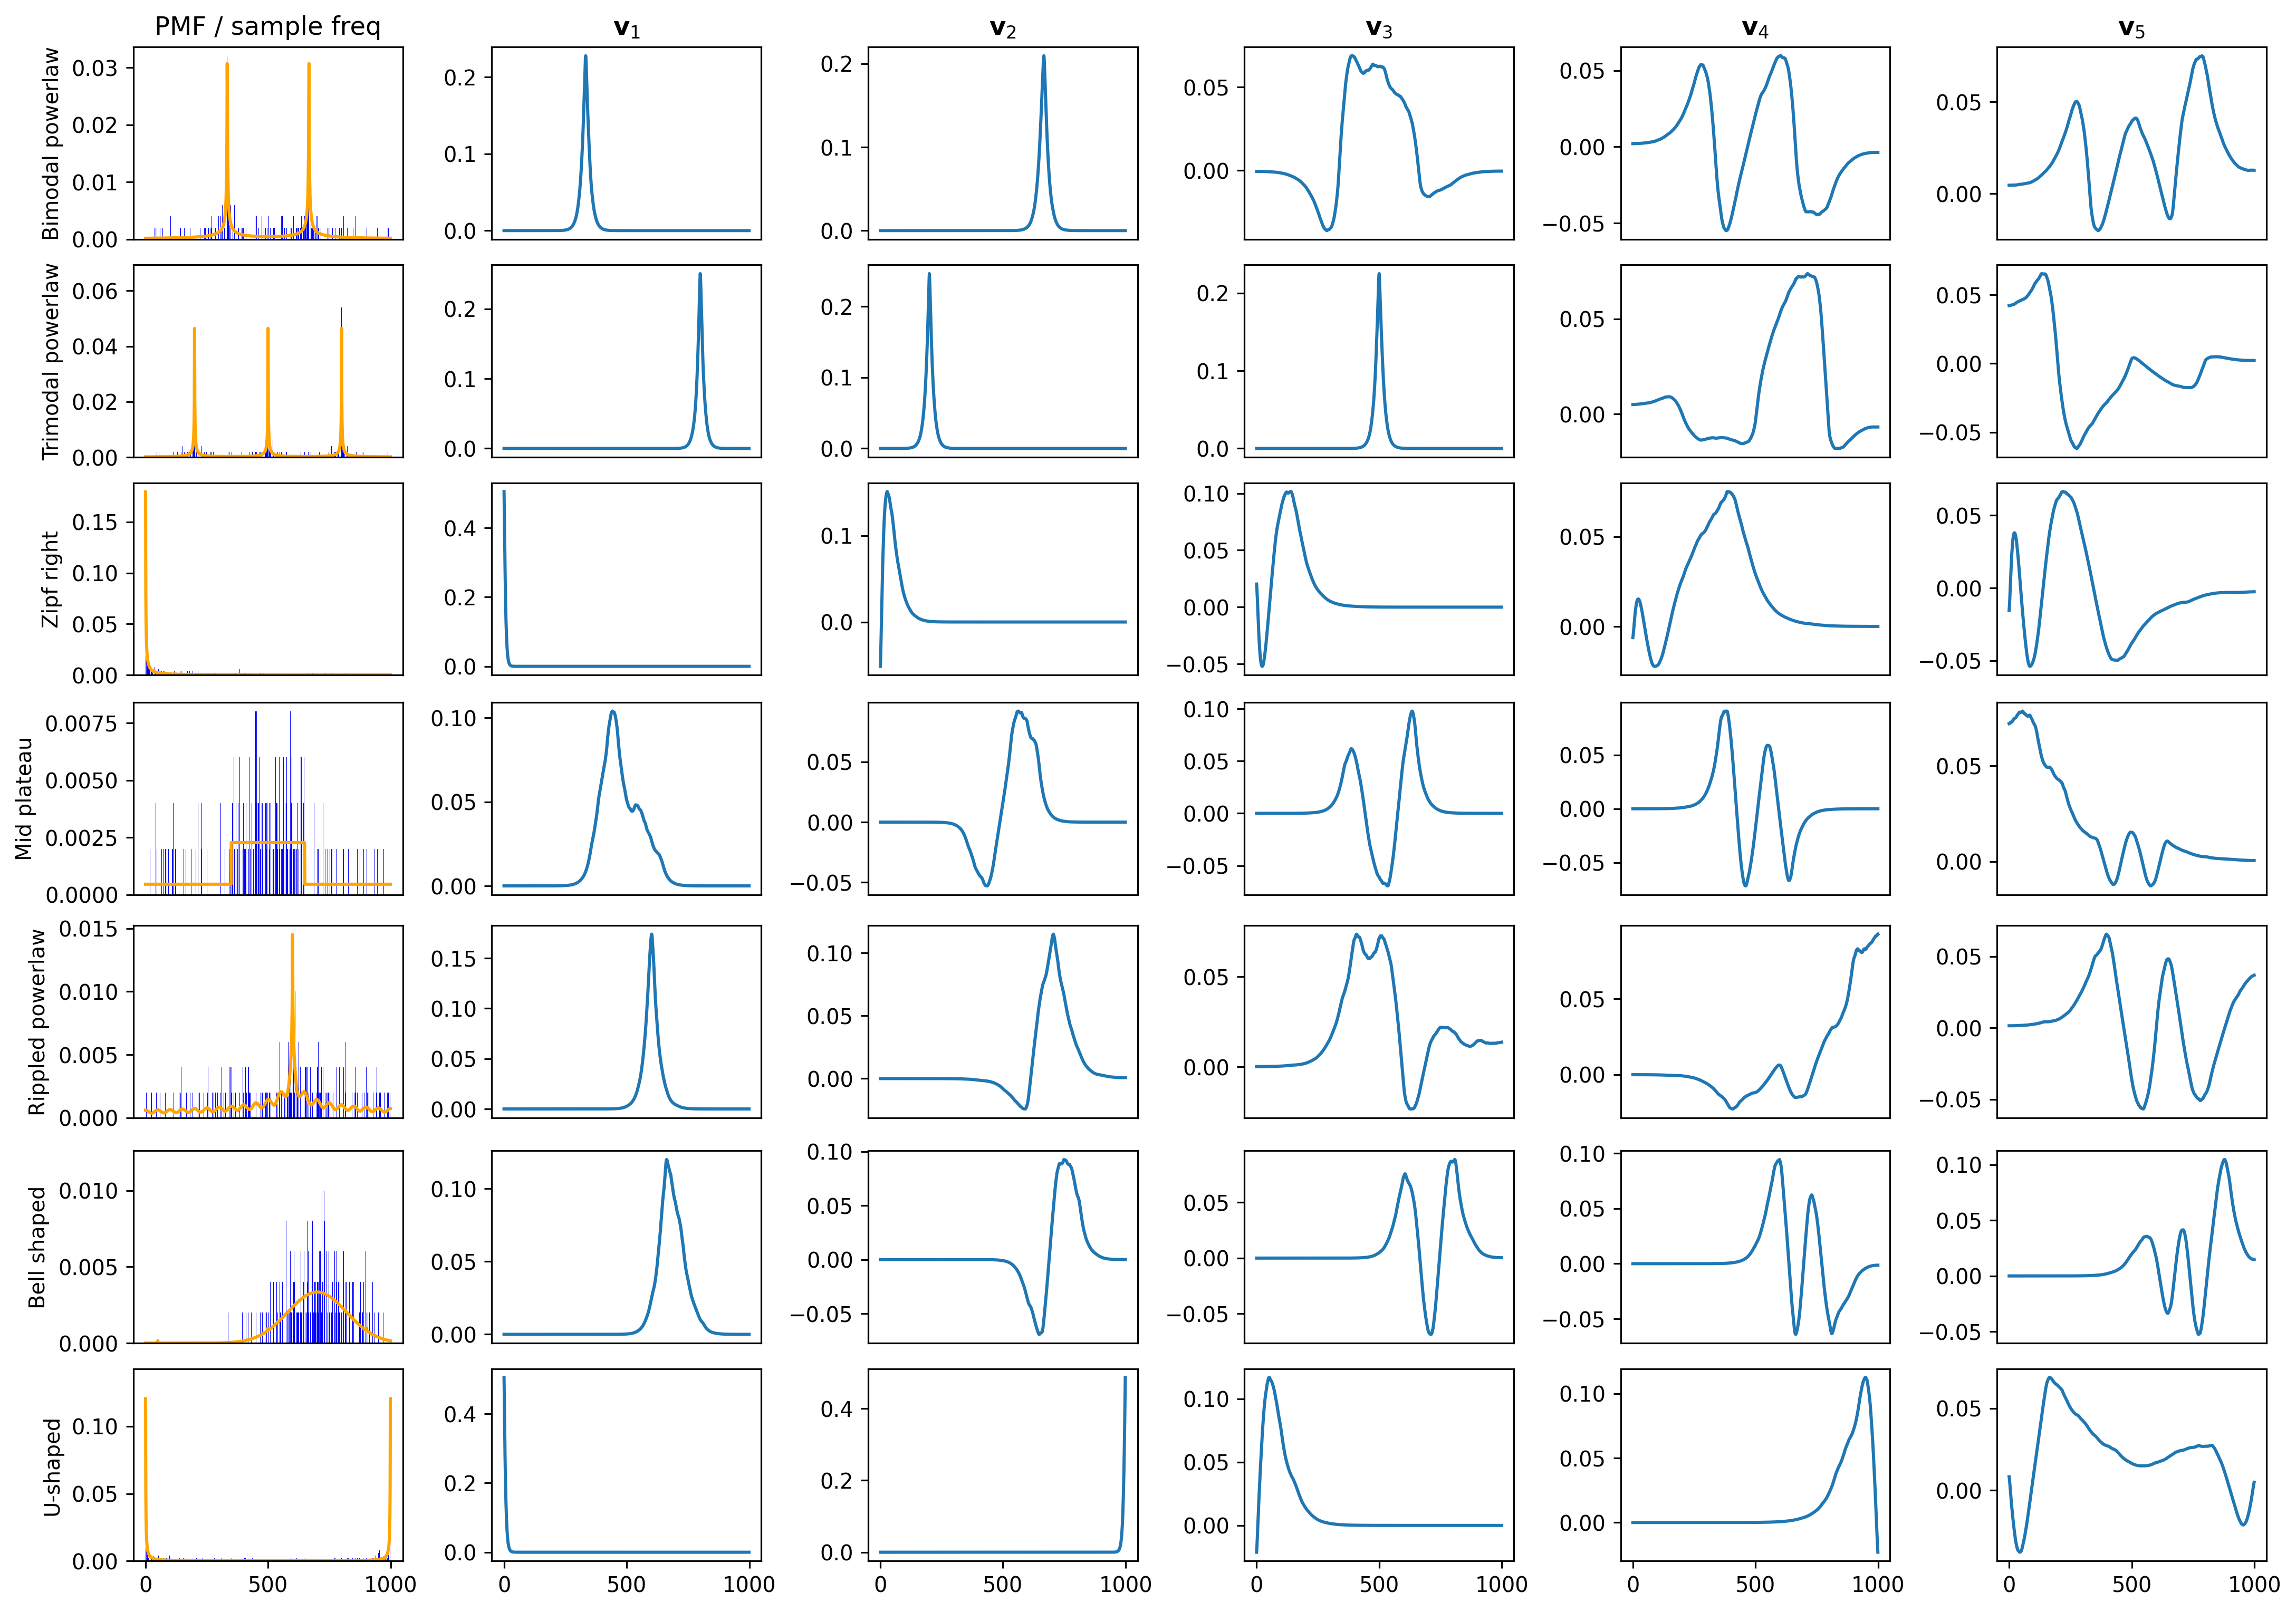

In [27]:
n_rows = len(distributions)
n_cols = min(1 + K_modes, 6)
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(2.5 * n_cols, 1.5 * n_rows))

for i, (dist_name, dist_weights) in enumerate(distributions):
    samples = sample_from_weights(dist_weights, n=500)
    empirical_hist = np.bincount(samples, minlength=max_val)
    empirical_hist = empirical_hist.astype(float) / np.sum(empirical_hist)
    _, eigvals, eigvecs = laplacian_porojection(empirical_hist, return_spectrum=True, num_coefs=K_modes)

    axs[i, 0].bar(xs, empirical_hist, color='blue')
    axs[i, 0].plot(xs, dist_weights, color='orange')
    axs[i, 0].set_ylabel(dist_name)
    if i == 0:
        axs[i, 0].set_title("PMF / sample freq")
    if i < n_rows - 1:
        axs[i, 0].tick_params(bottom=False, labelbottom=False)

    for j in range(1, n_cols):
        axs[i, j].plot(xs, eigvecs[:, j-1])
        if i == 0:
            axs[i, j].set_title(f'$\\mathbf{{v}}_{j}$')
        if i < n_rows - 1:
            axs[i, j].tick_params(bottom=False, labelbottom=False)

plt.show()

# Plot projections

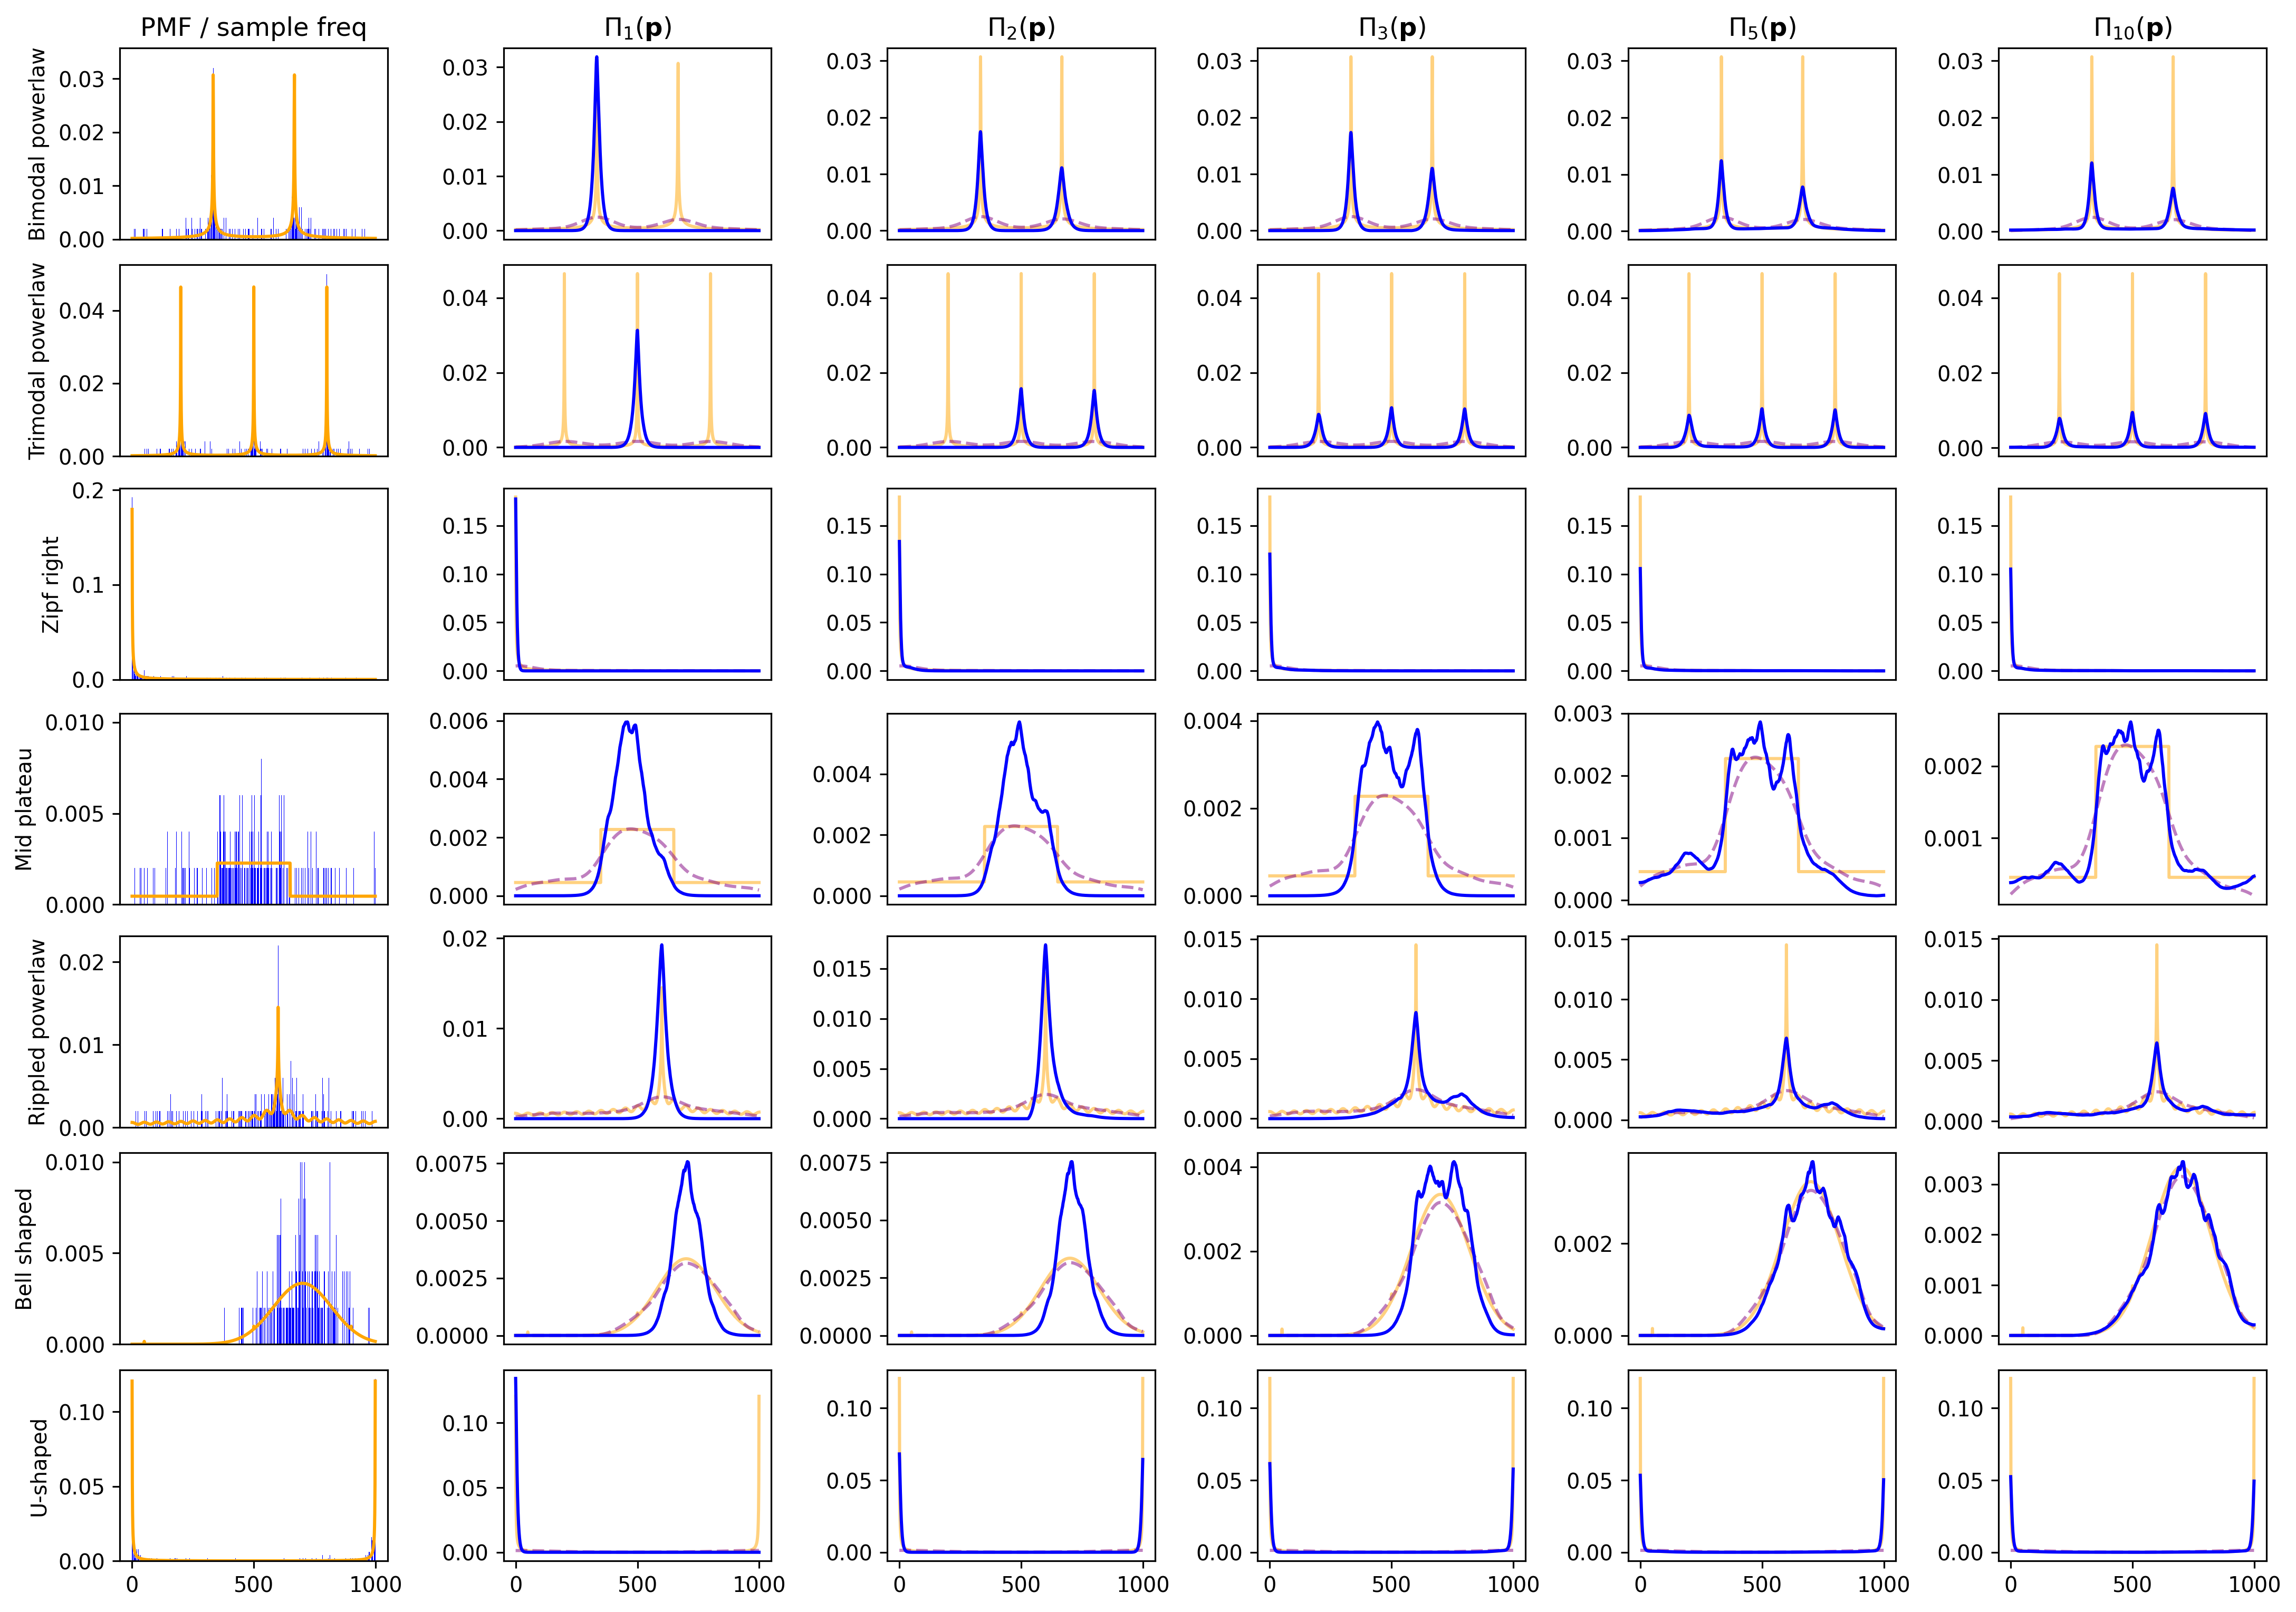

In [28]:
mode_numbers = [1, 2, 3, 5, 10]
n_rows = len(distributions)
n_cols = 1 + len(mode_numbers)
n_samples = 500
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(2.5 * n_cols, 1.5 * n_rows))

for i, (dist_name, dist_weights) in enumerate(distributions):
    samples = sample_from_weights(dist_weights, n=n_samples)
    empirical_hist = np.bincount(samples, minlength=max_val)
    empirical_hist = empirical_hist.astype(float) / np.sum(empirical_hist)

    axs[i, 0].bar(xs, empirical_hist, color='blue')
    axs[i, 0].plot(xs, dist_weights, color='orange')
    axs[i, 0].set_ylabel(dist_name)
    if i == 0:
        axs[i, 0].set_title("PMF / sample freq")
    if i < n_rows - 1:
        axs[i, 0].tick_params(bottom=False, labelbottom=False)

    for j in range(1, n_cols):
        proj = laplacian_porojection(empirical_hist, num_coefs=mode_numbers[j - 1])
        proj = normalize(proj)
        kde_est = kde_curve(samples)
        axs[i, j].plot(dist_weights, color='orange', alpha=0.5)
        axs[i, j].plot(kde_est, color='purple', linestyle='--', alpha=0.5)
        axs[i, j].plot(proj, color='blue')
        if i == 0:
            axs[i, j].set_title(f'$\\Pi_{{{mode_numbers[j - 1]}}}(\\mathbf{{p}})$')
        if i < n_rows - 1:
            axs[i, j].tick_params(bottom=False, labelbottom=False)

plt.show()

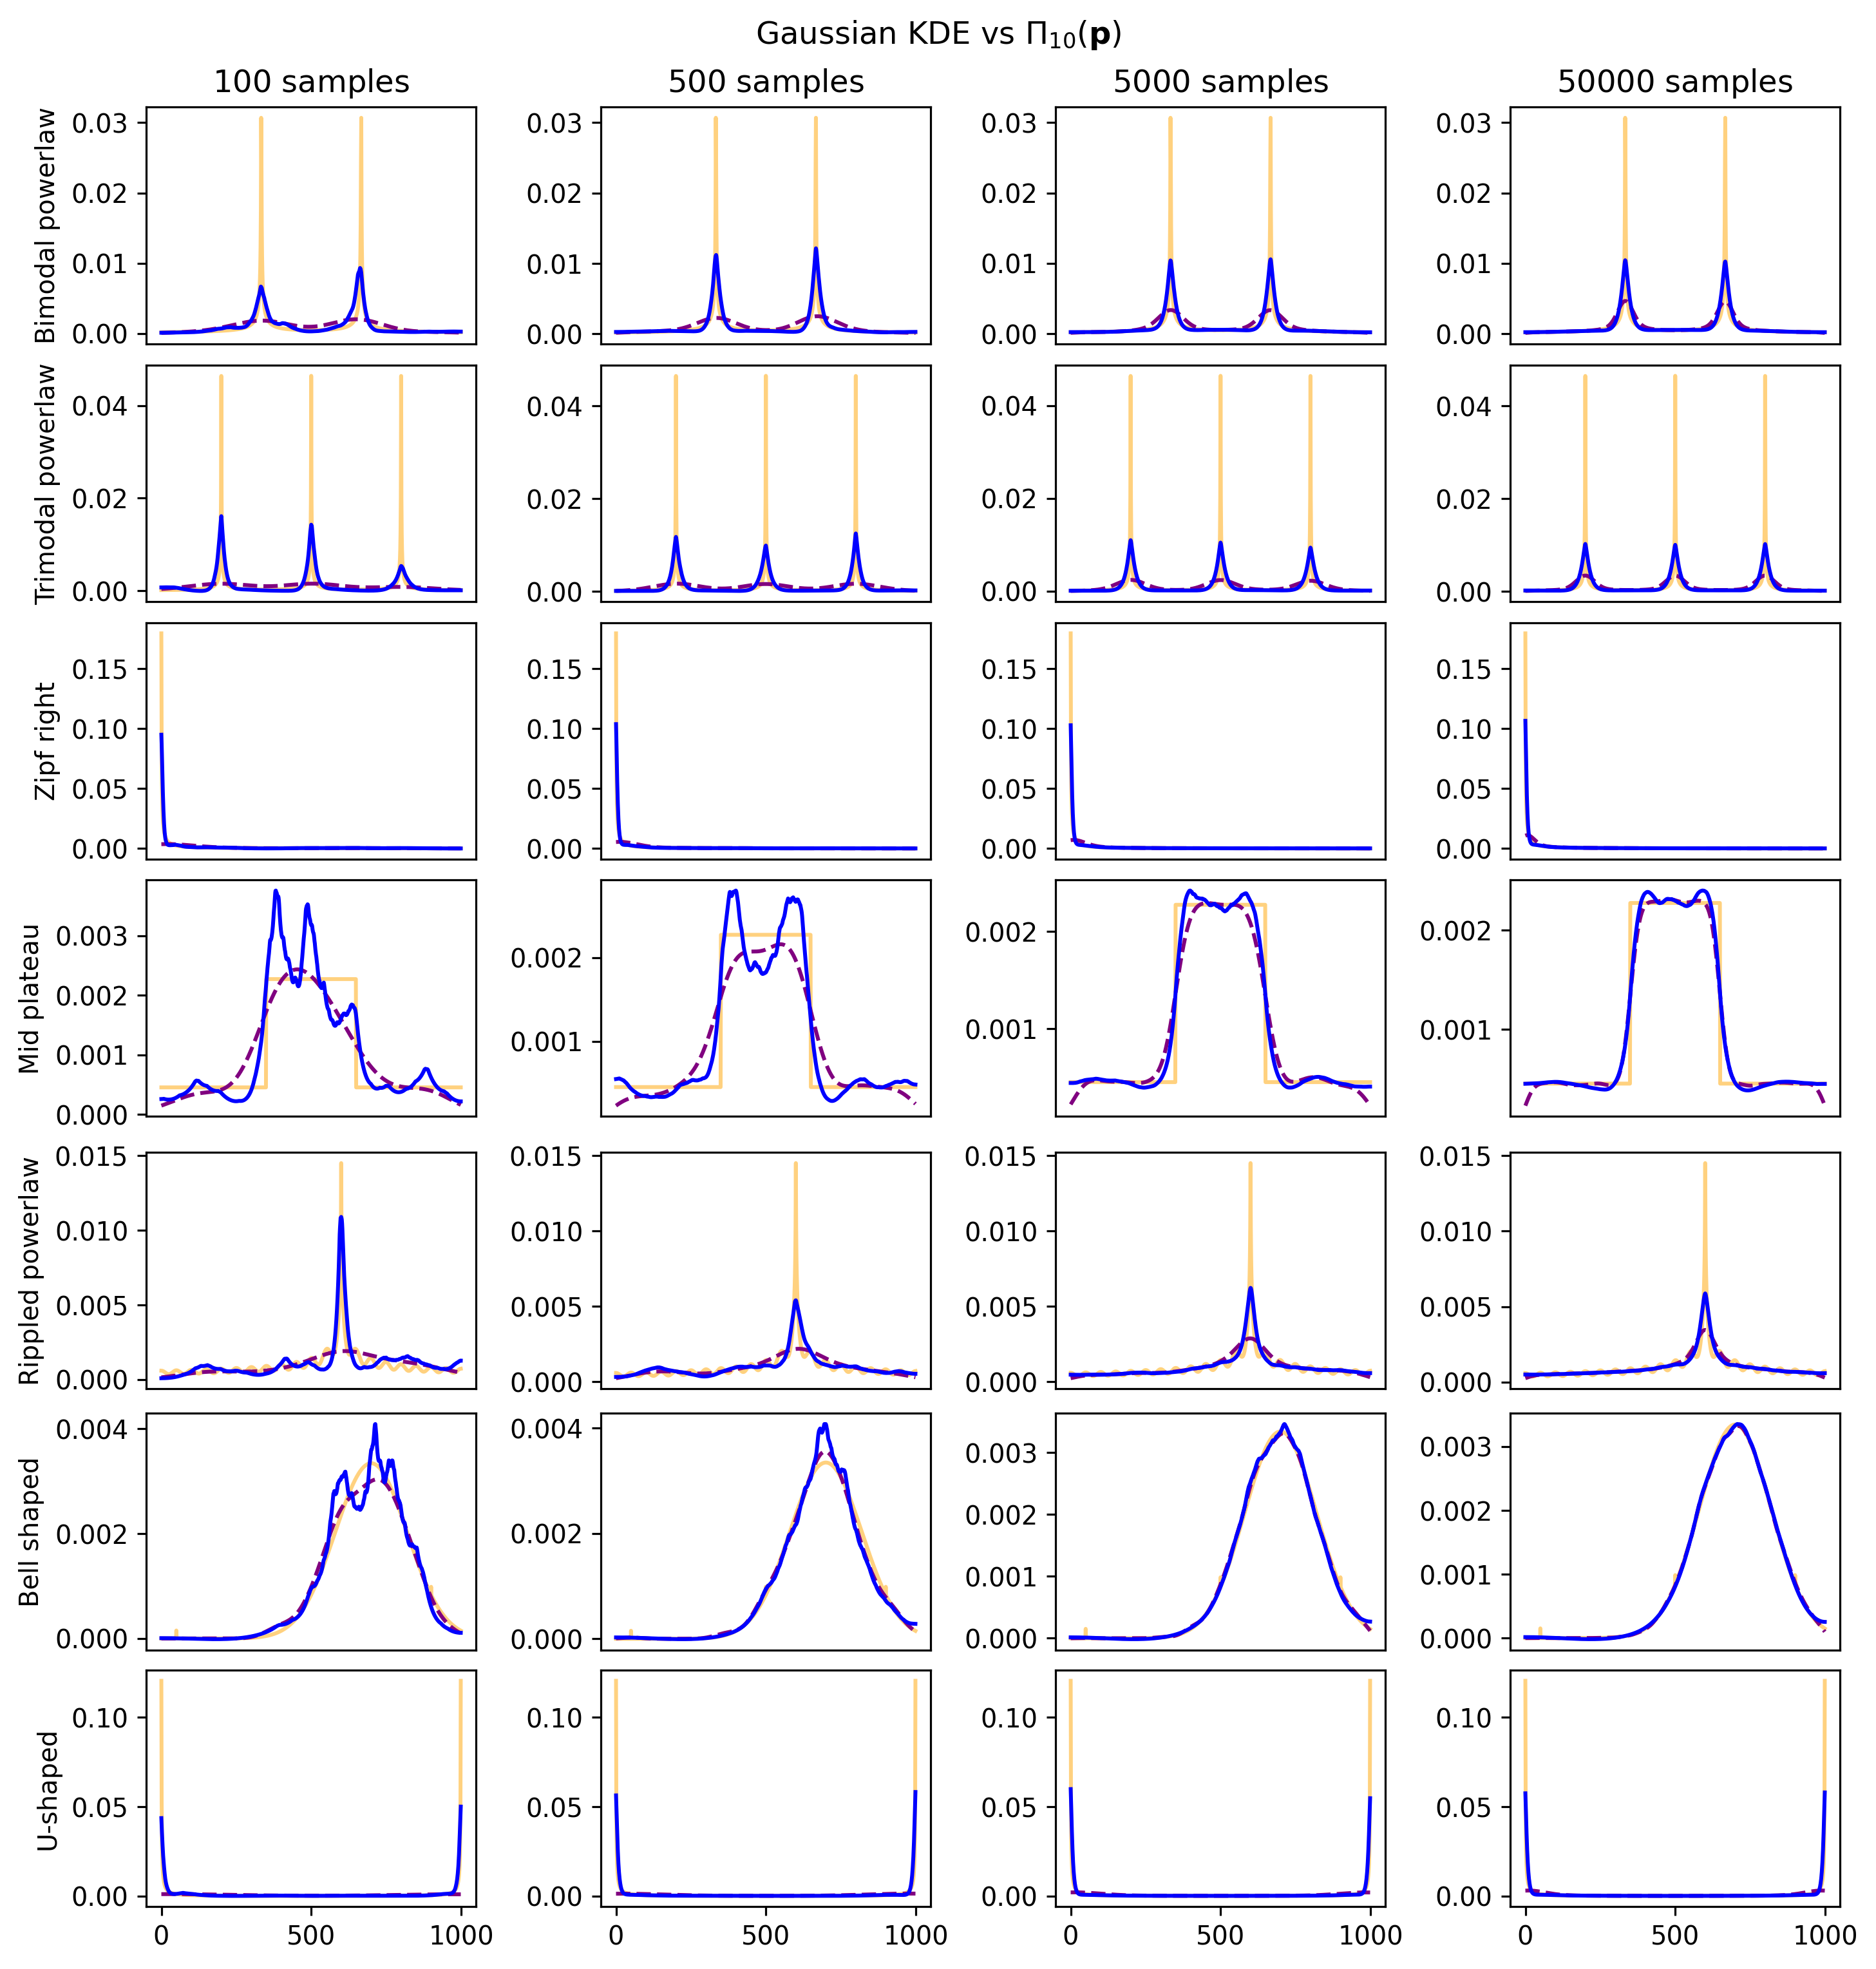

In [29]:
n_modes = 10
sample_sizes = [100, 500, 5000, 50000]
n_rows = len(distributions)
n_cols = len(sample_sizes)
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(2.5 * n_cols, 1.5 * n_rows))

fig.suptitle(f'Gaussian KDE vs $\\Pi_{{{n_modes}}}(\\mathbf{{p}})$')
for i, (dist_name, dist_weights) in enumerate(distributions):
    axs[i, 0].set_ylabel(dist_name)
    for j in range(n_cols):
        n_samples = sample_sizes[j]
        samples = sample_from_weights(dist_weights, n=n_samples)
        empirical_hist = np.bincount(samples, minlength=max_val)
        empirical_hist = empirical_hist.astype(float) / np.sum(empirical_hist)

        proj = laplacian_porojection(empirical_hist, num_coefs=n_modes)
        kde_est = kde_curve(samples)
        axs[i, j].plot(dist_weights, color='orange', alpha=0.5)
        axs[i, j].plot(kde_est, color='purple', linestyle='--')
        axs[i, j].plot(proj, color='blue')
        if i == 0:
            axs[i, j].set_title(f'${n_samples}$ samples')
        if i < n_rows - 1:
            axs[i, j].tick_params(bottom=False, labelbottom=False)

plt.show()

# As embeddings

In [58]:
weights = weights_bimodal_powerlaw()
samples = sample_from_weights(weights, n=500)

empirical_hist = np.bincount(samples, minlength=max_val)
empirical_hist = empirical_hist.astype(float) / np.sum(empirical_hist)

proj, evals, evecs = laplacian_porojection(empirical_hist, num_coefs=3, return_spectrum=True)

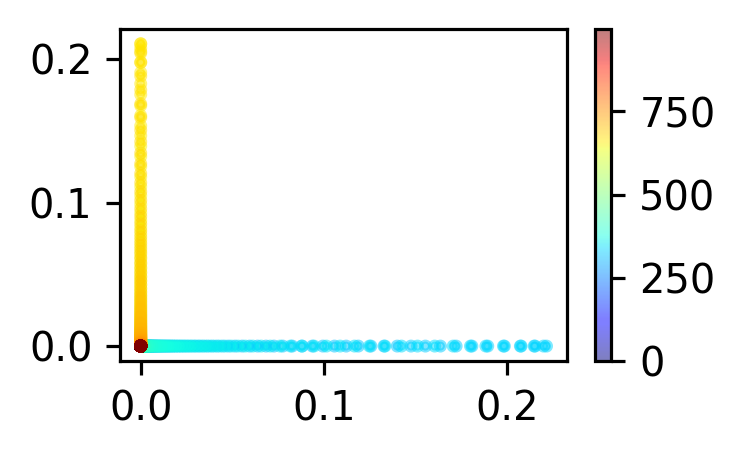

In [59]:
plt.figure(figsize=(2.5, 1.5))
plt.scatter(evecs[:, 0], evecs[:, 1], s=5, c=xs, alpha=0.5, cmap='jet')
plt.colorbar()

In [60]:
weights = weights_trimodal_powerlaw()
samples = sample_from_weights(weights, n=500)

empirical_hist = np.bincount(samples, minlength=max_val)
empirical_hist = empirical_hist.astype(float) / np.sum(empirical_hist)

proj, evals, evecs = laplacian_porojection(empirical_hist, num_coefs=3, return_spectrum=True)

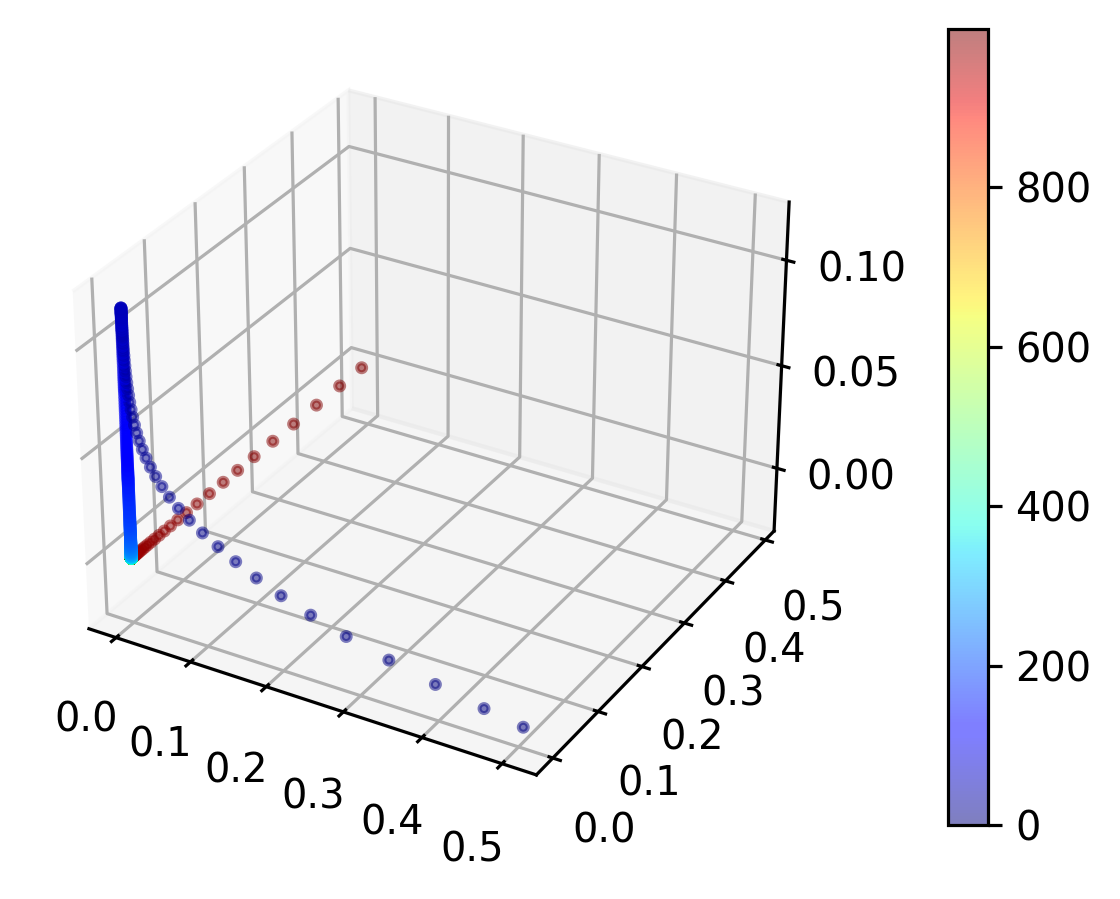

In [66]:
fig = plt.figure(layout='constrained')
ax = fig.add_subplot(projection='3d')
p = ax.scatter(eigvecs[:, 0], eigvecs[:, 1], eigvecs[:, 2], s=5, c=xs, alpha=0.5, cmap='jet')
fig.colorbar(p, ax=ax)